In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import copy
import time
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sktime.utils.slope_and_trend import _slope

In [79]:
class cecha:
    def __init__(self,pocz,kon, maxKon=1000):
        """
        pocz - początek przedziału na którym wyliczana jest cehca (włącznie)
        kon - koniec przedziału na którym wyliczana jest cecha (wyłącznie)
        """
        self.pocz=pocz
        self.kon=kon
        self.maxKon=maxKon
        
    def wartoscCechy(self,t):
        raise NotImplementedError

    def mutacjaLokalna(self):
        raise NotImplementedError
        
    def mutacjaPrzedzialu(self):
        szerokosc=3
        przesuniecie=np.random.randint(-szerokosc,szerokosc+1)
        if np.random.choice([True,False]):
            self.pocz+=przesuniecie
            self.pocz=max(self.pocz,0)
            self.pocz=min(self.pocz,self.kon-1)
        else:
            self.kon+=przesuniecie
            self.kon=min(self.kon,self.maxKon)
            self.kon=max(self.kon,self.pocz+1)
    
    def __str__(self):
        return f"Cecha ogólna, początek: {self.pocz}, koniec: {self.kon}"

In [80]:
class cechaSrednia(cecha):
    def __init__(self,pocz,kon, maxKon=10000):
        super().__init__(pocz,kon, maxKon)
        
    def wartoscCechy(self,t):
        if t.size<self.kon:
            return [np.nan]
        return [t[self.pocz:self.kon].mean()]
    
    def mutacjaLokalna(self):
        super().mutacjaPrzedzialu()
        
    def __str__(self):
        return f"Cecha wyliczająca średnią, początek: {self.pocz}, koniec: {self.kon}"

In [81]:
class cechaOdchylenieStandardowe(cecha):
    def __init__(self,pocz,kon, maxKon=10000):
        super().__init__(pocz,kon, maxKon)
        
    def wartoscCechy(self,t):
        if t.size<self.kon:
            return [np.nan]
        return [t[self.pocz:self.kon].std()]
    
    def mutacjaLokalna(self):
        super().mutacjaPrzedzialu()
    
    def __str__(self):
        return f"Cecha wyliczająca odchylenie standardowe, początek: {self.pocz}, koniec: {self.kon}"

In [82]:
class cechaOdchylenieMiedzyKwartylami(cecha):
    def __init__(self,pocz,kon, maxKon=10000):
        super().__init__(pocz,kon, maxKon)
        
    def wartoscCechy(self,t):
        if t.size<self.kon:
            return [np.nan]
        wycinek=np.sort(t[self.pocz:self.kon])
        dane=wycinek[int(wycinek.size*0.25):int(wycinek.size*0.75)+1]
        return [dane.std()]
    
    def mutacjaLokalna(self):
        super().mutacjaPrzedzialu()
    
    def __str__(self):
        return f"Cecha wyliczająca odchylenie standardowe między pierwszym i trzecim kwartylem, początek: {self.pocz}, koniec: {self.kon}"

In [83]:
class cechaSredniaMiedzyKwartylami(cecha):
    def __init__(self,pocz,kon, maxKon=10000):
        super().__init__(pocz,kon, maxKon)
        
    def wartoscCechy(self,t):
        if t.size<self.kon:
            return [np.nan]
        wycinek=np.sort(t[self.pocz:self.kon])
        dane=wycinek[int(wycinek.size*0.25):int(wycinek.size*0.75)+1]
        return [dane.mean()]
    
    def mutacjaLokalna(self):
        super().mutacjaPrzedzialu()
        
    def __str__(self):
        return f"Cecha wyliczająca średnią między pierwszym i trzecim kwartylem, początek: {self.pocz}, koniec: {self.kon}"

In [88]:
class cechaRegresjaLin(cecha):
    def __init__(self,pocz,kon, maxKon=10000,wymiar=1):
        super().__init__(pocz,kon, maxKon)
        self.wymiar=wymiar
        
    def wartoscCechy(self,t):
        if t.size<self.kon:
            return [np.nan]*(self.wymiar+1)
        wycinek=t[self.pocz:self.kon]
        dane=[]
        dane.append(np.ones(len(wycinek)))
        for i in range(1,self.wymiar+1):
            dane.append(np.arange(len(wycinek))**i)
        dane=np.array(dane).T
        
        model=LinearRegression()
        model.fit(dane,wycinek)
        return list(model.coef_)
    
    def mutacjaLokalna(self):
        if np.random.rand()<0.15:
            if np.random.randint(0,2)==0:
                self.wymiar+=1
                self.wymiar=min(self.wymiar,4)
            else:
                self.wymiar-=1
                self.wymiar=max(0,self.wymiar)
        else:
            super().mutacjaPrzedzialu()
    
    def __str__(self):
        return f"Cecha wyliczająca regresję liniową, początek: {self.pocz}, koniec: {self.kon}, stopień wielomianu: {self.wymiar}"

In [85]:
class zbiorCech:
    def __init__(self):
        self.cechy=[]
    
    def wylosujCeche(self):
        ind=np.random.randint(0,len(self.cechy))
        return ind,self.cechy[ind]
    
    def opiszSzereg(self,t):
        listaCech=[]
        for cecha in self.cechy:
            listaCech+=cecha.wartoscCechy(t)
        return listaCech
    
    def opiszZbiorSzeregow(self,T):
        listaOpisow=[self.opiszSzereg(t) for t in T]
        return np.array(listaOpisow)
    
    def __str__(self):
        opisy=[str(cecha) for cecha in self.cechy]
        return "\n".join(opisy)

In [93]:
class AlgorytmEwolucyjny:
    def __init__(self,koncowaLiczbaCech=20,liczbaIteracjiMiedzyDodaniemCech=10,
                liczbaCechGenerowanychPrzyDodawaniu=10,
                glebokoscDrzew=6, liczbaDzieci=10):
        self.zbior=zbiorCech()
        self.koncowaLiczbaCech=koncowaLiczbaCech
        self.liczbaIteracjiMiedzyDodaniemCech=liczbaIteracjiMiedzyDodaniemCech
        self.liczbaCechGenerowanychPrzyDodawaniu=liczbaCechGenerowanychPrzyDodawaniu
        self.glebokoscDrzew=glebokoscDrzew
        self.liczbaDzieci=liczbaDzieci
        self.historia=[]
        self.najlepszyWynik=0
        self.najlepszyZbior=None
    
    def losujNowaCeche(self,n):
        """
        n - spodziewana długość szeregu czasowego (używane do określenia końca cechy)
        """
        r=np.random.choice(np.arange(5))
        pocz,kon=np.sort(np.random.randint(0,n-1,size=2))
        kon+=1
        if r==0:
            c=cechaSrednia(pocz,kon,n)
        elif r==1:
            c=cechaOdchylenieStandardowe(pocz,kon,n)
        elif r==2:
            c=cechaSredniaMiedzyKwartylami(pocz,kon,n)
        elif r==3:
            c=cechaOdchylenieMiedzyKwartylami(pocz,kon,n)
        elif r==4:
            w=np.random.randint(0,3)
            c=cechaRegresjaLin(pocz,kon,maxKon=n, wymiar=w)
        else:
            raise RuntimeError("Wylosowano typ cechy, który nie jest przypisany do żadnego obiektu.")
        #print(c.pocz, c.kon)
        return c

    def wyliczDokladnoscZbioru(self, T_train,Y_train,T_test,Y_test, zbiorSprawdzany=None):
        if zbiorSprawdzany is None:
            zbiorSprawdzany=self.zbior
        #self.debug_zbiorSprawdzany=zbiorSprawdzany
        opisT_train=zbiorSprawdzany.opiszZbiorSzeregow(T_train)
        opisT_test=zbiorSprawdzany.opiszZbiorSzeregow(T_test)
        #print(opisT_train)
        #print(opisT_test)
        las=RandomForestClassifier(max_depth=self.glebokoscDrzew, n_jobs=-1)
        las.fit(opisT_train,Y_train)
        return las.score(opisT_test,Y_test)
    
    def dodajCeche(self,T_train,Y_train,T_test,Y_test):
        n=len(T_train[0])
        wygenerowaneCechy=[self.losujNowaCeche(n) for i in range(self.liczbaCechGenerowanychPrzyDodawaniu)]
        #self.debug_wygenerowaneCechy=wygenerowaneCechy
        wyniki=[]
        for i in range(self.liczbaCechGenerowanychPrzyDodawaniu):
            zbiorTymczasowy=copy.deepcopy(self.zbior)
            zbiorTymczasowy.cechy.append(wygenerowaneCechy[i])
            wyniki.append(self.wyliczDokladnoscZbioru(T_train,Y_train,T_test,Y_test, zbiorSprawdzany=zbiorTymczasowy))
        ind=np.argmax(wyniki)
        self.zbior.cechy.append(wygenerowaneCechy[ind])
        
    def ewolucjaMiedzyDodaniami(self,T_train,Y_train,T_test,Y_test):
        for i in range(self.liczbaIteracjiMiedzyDodaniemCech):
            #print("Ewolucja między dodaniami:",i)
            ind,cechaMutowana=self.zbior.wylosujCeche()
            dzieci=[copy.deepcopy(cechaMutowana) for j in range(self.liczbaDzieci)]
            for cecha in dzieci:
                cecha.mutacjaLokalna()
            #print(dzieci)
            wyniki=[]
            self.zbior.cechy.pop(ind)
            for j in range(self.liczbaDzieci):
                zbiorTymczasowy=copy.deepcopy(self.zbior)
                zbiorTymczasowy.cechy.append(dzieci[j])
                wyniki.append(self.wyliczDokladnoscZbioru(T_train,Y_train,T_test,Y_test, zbiorSprawdzany=zbiorTymczasowy))
            indWyniku=np.argmax(wyniki)
            self.zbior.cechy.append(dzieci[indWyniku])
            self.historia.append(wyniki[indWyniku])
            if self.najlepszyWynik<wyniki[indWyniku]:
                self.najlepszyWynik=wyniki[indWyniku]
                self.najlepszyZbior=copy.deepcopy(self.zbior)
    
    def ewoluuj(self, T_train,Y_train,T_test,Y_test):
        """
        T - lista szeregów czasowych
        """
        for i in range(self.koncowaLiczbaCech):
            t=time.time()
            self.dodajCeche(T_train,Y_train,T_test,Y_test)
            
            self.historia.append(self.wyliczDokladnoscZbioru(T_train,Y_train,T_test,Y_test))
            if self.najlepszyWynik<self.historia[-1]:
                self.najlepszyWynik=self.historia[-1]
                self.najlepszyZbior=copy.deepcopy(self.zbior)
                
            self.ewolucjaMiedzyDodaniami(T_train,Y_train,T_test,Y_test)
            print(f"Pokolenie {i}, wynik: {self.historia[-1]}, czas: {time.time()-t}")
            
    def rysujHistorie(self):
        plt.plot(self.historia)

# Arrow

In [142]:
arrow_train=np.loadtxt("Dane/ArrowHead_TRAIN.txt")
X_train=arrow_train[:,1:]
Y_train=np.array(arrow_train[:,0],dtype=int)

arrow_test=np.loadtxt("Dane/ArrowHead_TEST.txt")
X_test=arrow_test[:,1:]
Y_test=np.array(arrow_test[:,0],dtype=int)

Pokolenie 0, wynik: 0.7314285714285714, czas: 33.90136957168579
Pokolenie 1, wynik: 0.76, czas: 35.73584818840027
Pokolenie 2, wynik: 0.8114285714285714, czas: 36.37594246864319
Pokolenie 3, wynik: 0.7942857142857143, czas: 37.36486220359802
Pokolenie 4, wynik: 0.7885714285714286, czas: 38.322030544281006
Pokolenie 5, wynik: 0.8228571428571428, czas: 51.263877630233765
Pokolenie 6, wynik: 0.8228571428571428, czas: 55.5202910900116
Pokolenie 7, wynik: 0.8514285714285714, czas: 64.49031782150269
Pokolenie 8, wynik: 0.8457142857142858, czas: 67.16256332397461
Pokolenie 9, wynik: 0.8457142857142858, czas: 78.59368062019348
Pokolenie 10, wynik: 0.8285714285714286, czas: 88.94857144355774
Pokolenie 11, wynik: 0.8342857142857143, czas: 91.98640656471252
Pokolenie 12, wynik: 0.8685714285714285, czas: 93.83698391914368
Pokolenie 13, wynik: 0.8514285714285714, czas: 95.15535593032837
Pokolenie 14, wynik: 0.8571428571428571, czas: 95.72954773902893
Pokolenie 15, wynik: 0.8457142857142858, czas: 9

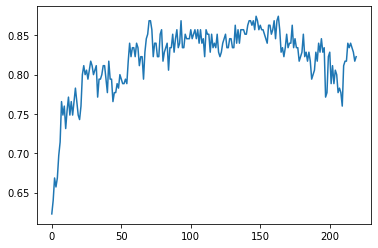

In [96]:
model=AlgorytmEwolucyjny(liczbaIteracjiMiedzyDodaniemCech=10, liczbaDzieci=10, 
                         liczbaCechGenerowanychPrzyDodawaniu=20,
                        glebokoscDrzew=10)
model.ewoluuj(X_train, Y_train, X_test,Y_test)
model.rysujHistorie()

In [97]:
#Ograniczenie głębokości drzew do 10
print(model.najlepszyWynik)
print(model.najlepszyZbior)

0.8742857142857143
Cecha wyliczająca średnią między pierwszym i trzecim kwartylem, początek: 37, koniec: 233
Cecha wyliczająca regresję liniową, początek: 37, koniec: 74, stopień wielomianu: 2
Cecha wyliczająca średnią między pierwszym i trzecim kwartylem, początek: 143, koniec: 215
Cecha wyliczająca odchylenie standardowe między pierwszym i trzecim kwartylem, początek: 17, koniec: 48
Cecha wyliczająca średnią, początek: 2, koniec: 243
Cecha wyliczająca regresję liniową, początek: 64, koniec: 170, stopień wielomianu: 0
Cecha wyliczająca średnią, początek: 131, koniec: 179
Cecha wyliczająca regresję liniową, początek: 5, koniec: 134, stopień wielomianu: 2
Cecha wyliczająca średnią między pierwszym i trzecim kwartylem, początek: 30, koniec: 32
Cecha wyliczająca regresję liniową, początek: 57, koniec: 247, stopień wielomianu: 1
Cecha wyliczająca odchylenie standardowe między pierwszym i trzecim kwartylem, początek: 142, koniec: 164
Cecha wyliczająca regresję liniową, początek: 36, koniec:

##### Ograniczenie głębokości drzew do 6
- 0.8628571428571429
- Cecha wyliczająca średnią, początek: 149, koniec: 239
- Cecha wyliczająca średnią, początek: 194, koniec: 210
- Cecha wyliczająca regresję liniową, początek: 113, koniec: 127, stopień wielomianu: 1
- Cecha wyliczająca średnią między pierwszym i trzecim kwartylem, początek: 52, koniec: 138
- Cecha wyliczająca regresję liniową, początek: 127, koniec: 176, stopień wielomianu: 0
- Cecha wyliczająca średnią, początek: 38, koniec: 162
- Cecha wyliczająca średnią, początek: 146, koniec: 209
- Cecha wyliczająca średnią między pierwszym i trzecim kwartylem, początek: 27, koniec: 150

##### Ograniczenie głębokości drzew do 10
- 0.8742857142857143
- Cecha wyliczająca średnią między pierwszym i trzecim kwartylem, początek: 37, koniec: 233
- Cecha wyliczająca regresję liniową, początek: 37, koniec: 74, stopień wielomianu: 2
- Cecha wyliczająca średnią między pierwszym i trzecim kwartylem, początek: 143, koniec: 215
- Cecha wyliczająca odchylenie standardowe między pierwszym i trzecim kwartylem, początek: 17, koniec: 48
- Cecha wyliczająca średnią, początek: 2, koniec: 243
- Cecha wyliczająca regresję liniową, początek: 64, koniec: 170, stopień wielomianu: 0
- Cecha wyliczająca średnią, początek: 131, koniec: 179
- Cecha wyliczająca regresję liniową, początek: 5, koniec: 134, stopień wielomianu: 2
- Cecha wyliczająca średnią między pierwszym i trzecim kwartylem, początek: 30, koniec: 32
- Cecha wyliczająca regresję liniową, początek: 57, koniec: 247, stopień wielomianu: 1
- Cecha wyliczająca odchylenie standardowe między pierwszym i trzecim kwartylem, początek: 142, koniec: 164
- Cecha wyliczająca regresję liniową, początek: 36, koniec: 89, stopień wielomianu: 3
- Cecha wyliczająca średnią między pierwszym i trzecim kwartylem, początek: 168, koniec: 225
- Cecha wyliczająca odchylenie standardowe między pierwszym i trzecim kwartylem, początek: 228, koniec: 238

https://people.eng.unimelb.edu.au/jianzhongq/papers/ICDM2020_TimeSeriesClassificationViaIntervalSearch.pdf

### Sktime

In [147]:
for n in [3,5,7,10,15,20,40,60,80,100]:
    extractor=RandomIntervalFeatureExtractor(n_intervals=n, features=[np.mean, np.std, _slope])

    X_tmp=np.resize(X_train,(X_train.shape[0],1,X_train.shape[1]))
    X_train_transf=extractor.fit_transform(X_tmp)
    X_tmp=np.resize(X_test,(X_test.shape[0],1,X_test.shape[1]))
    X_test_transf=extractor.fit_transform(X_tmp)
    
    model=RandomForestClassifier(max_depth=20,n_jobs=-1)
    model.fit(X_train_transf,Y_train)
    print(model.score(X_test_transf,Y_test))

0.19428571428571428
0.3028571428571429
0.37714285714285717
0.32571428571428573
0.38857142857142857
0.3028571428571429
0.4685714285714286
0.37714285714285717
0.5257142857142857
0.3314285714285714


# Basic motions 

In [139]:
with open("Dane/BasicMotions_TRAIN.ts","r") as plik:
    for i in range(13):
        plik.readline()
    klasy=[]
    dane=[]
    for linia in plik:
        podzial=linia.split(":")
        klasy.append(podzial[-1][:-1])
        dane.append([float(i) for i in podzial[0].split(",")])
X_train=np.array(dane)
Y_train=np.array(klasy)
with open("Dane/BasicMotions_TEST.ts","r") as plik:
    for i in range(13):
        plik.readline()
    klasy=[]
    dane=[]
    for linia in plik:
        podzial=linia.split(":")
        klasy.append(podzial[-1][:-1])
        dane.append([float(i) for i in podzial[0].split(",")])
X_test=np.array(dane)
Y_test=np.array(klasy)

Pokolenie 0, wynik: 1.0, czas: 24.056366682052612
Pokolenie 1, wynik: 1.0, czas: 24.447043895721436
Pokolenie 2, wynik: 1.0, czas: 24.869303703308105
Pokolenie 3, wynik: 1.0, czas: 25.179675817489624
Pokolenie 4, wynik: 1.0, czas: 25.823121547698975
Pokolenie 5, wynik: 1.0, czas: 25.95850944519043
Pokolenie 6, wynik: 1.0, czas: 26.149118423461914
Pokolenie 7, wynik: 1.0, czas: 28.54008960723877
Pokolenie 8, wynik: 1.0, czas: 29.3789541721344
Pokolenie 9, wynik: 1.0, czas: 29.53005075454712
Pokolenie 10, wynik: 1.0, czas: 29.615303993225098
Pokolenie 11, wynik: 1.0, czas: 30.04591965675354
Pokolenie 12, wynik: 1.0, czas: 30.310298681259155
Pokolenie 13, wynik: 1.0, czas: 30.622214794158936
Pokolenie 14, wynik: 1.0, czas: 31.0938720703125
Pokolenie 15, wynik: 1.0, czas: 31.51923632621765
Pokolenie 16, wynik: 1.0, czas: 34.599589109420776
Pokolenie 17, wynik: 1.0, czas: 35.379518270492554
Pokolenie 18, wynik: 1.0, czas: 36.549567461013794
Pokolenie 19, wynik: 1.0, czas: 39.115708112716675

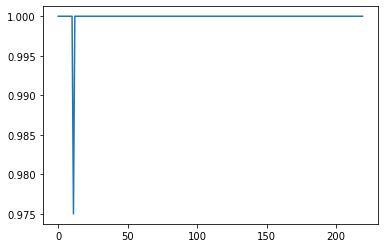

In [99]:
model=AlgorytmEwolucyjny(liczbaIteracjiMiedzyDodaniemCech=10, liczbaDzieci=10, 
                         liczbaCechGenerowanychPrzyDodawaniu=20,
                        glebokoscDrzew=10)
model.ewoluuj(X_train, Y_train, X_test,Y_test)
model.rysujHistorie()

In [100]:
#Ograniczenie głębokości drzew do 10
print(model.najlepszyWynik)
print(model.najlepszyZbior)

1.0
Cecha wyliczająca odchylenie standardowe, początek: 42, koniec: 83


### Sktime

In [140]:
for n in [3,5,7,10,15]:
    extractor=RandomIntervalFeatureExtractor(n_intervals=n, features=[np.mean, np.std, _slope])

    X_tmp=np.resize(X_train,(X_train.shape[0],1,X_train.shape[1]))
    X_train_transf=extractor.fit_transform(X_tmp)
    X_tmp=np.resize(X_test,(X_test.shape[0],1,X_test.shape[1]))
    X_test_transf=extractor.fit_transform(X_tmp)
    
    model=RandomForestClassifier(max_depth=10,n_jobs=-1)
    model.fit(X_train_transf,Y_train)
    print(model.score(X_test_transf,Y_test))

0.925
0.925
1.0
0.9
0.975
